# Import Libraries

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [3]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

# Plot Examples

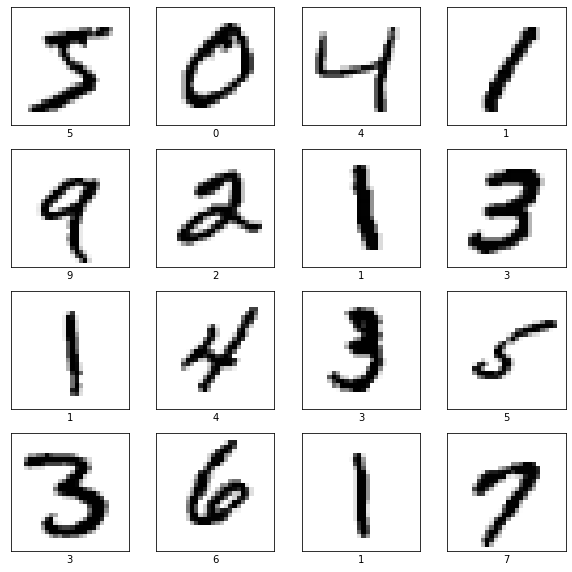

In [4]:
plt.figure(figsize=(10,10))
for i in range(0,16) :
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap='binary')
    plt.xlabel(str(y_train[i]))
    plt.xticks([])
    plt.yticks([])
           
plt.show()

# Normalize Data

In [5]:
x_train = np.reshape(x_train,(60000,28*28))
x_test = np.reshape(x_test,(10000,28*28))

In [6]:
x_train = x_train/255.
x_test = x_test/255.

# Create a Neural Network Model

In [10]:
model = tf.keras.models.Sequential(
    [tf.keras.layers.Dense(32,activation='sigmoid',input_shape=(784,)),
     tf.keras.layers.Dense(32,activation='sigmoid'),
     tf.keras.layers.Dense(10,activation='softmax')])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the Model

In [12]:
_ =model.fit(
             x_train,y_train,
             validation_data = (x_test,y_test),
             epochs=50,
             batch_size=1024,
             verbose=2)

Epoch 1/50
59/59 - 1s - loss: 0.3479 - accuracy: 0.9161 - val_loss: 0.3341 - val_accuracy: 0.9185
Epoch 2/50
59/59 - 0s - loss: 0.3226 - accuracy: 0.9204 - val_loss: 0.3130 - val_accuracy: 0.9208
Epoch 3/50
59/59 - 1s - loss: 0.3020 - accuracy: 0.9243 - val_loss: 0.2957 - val_accuracy: 0.9232
Epoch 4/50
59/59 - 1s - loss: 0.2847 - accuracy: 0.9274 - val_loss: 0.2812 - val_accuracy: 0.9254
Epoch 5/50
59/59 - 1s - loss: 0.2695 - accuracy: 0.9310 - val_loss: 0.2680 - val_accuracy: 0.9282
Epoch 6/50
59/59 - 1s - loss: 0.2566 - accuracy: 0.9336 - val_loss: 0.2573 - val_accuracy: 0.9303
Epoch 7/50
59/59 - 1s - loss: 0.2450 - accuracy: 0.9363 - val_loss: 0.2491 - val_accuracy: 0.9315
Epoch 8/50
59/59 - 0s - loss: 0.2350 - accuracy: 0.9383 - val_loss: 0.2396 - val_accuracy: 0.9348
Epoch 9/50
59/59 - 0s - loss: 0.2256 - accuracy: 0.9406 - val_loss: 0.2305 - val_accuracy: 0.9358
Epoch 10/50
59/59 - 0s - loss: 0.2173 - accuracy: 0.9423 - val_loss: 0.2238 - val_accuracy: 0.9363
Epoch 11/50
59/59 -

# Save the Model

In [13]:
model.save('model.h5')

# ML Server

In [17]:
%%writefile ml_server.py

import json 
import tensorflow as tf
import numpy as np 
import random 
from flask import Flask , request

app = Flask(__name__)

model = tf.keras.models.load_model('model.h5')
feature_model = tf.keras.models.Model(model.inputs,
                                     [layer.output for layer in model.layers])

_,(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test/255.0
def get_prediction():
    index = np.random.choice(x_test.shape[0])
    image = x_test[index,:,:]
    image_array = np.reshape(image,(1,784))
    return feature_model.predict(image_array),image


@app.route('/' , methods = ['GET','POST'])
def index():
    if request.method =='POST':
        preds,image = get_prediction()
        final_preds = [p.tolist() for p in preds]
        return json.dumps({'predictions':final_preds,
                          'image' : image.tolist()})
    return 'Welcome to the model server'

if __name__ =='__main__' :
    app.run()

Overwriting ml_server.py


# Streamlit Web App

In [35]:
%%writefile app.py

import streamlit as st
import json 
import requests
import matplotlib.pyplot as plt 
import numpy as np

URI = 'http://127.0.0.1:5000'
st.title('Neural Network Visualizer')
st.sidebar.markdown('## Input Image')

if st.button('Get random prediction'):
    response = requests.post(URI,data={})
    response = json.loads(response.text)
    preds = response.get('predictions')
    image = response.get('image')
    image = np.reshape(image,(28,28))
    st.sidebar.image(image,width=150)
    
    for layer,p in enumerate(preds):
        numbers = np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        if layer == 2:
            row=1
            col=10
        else:
            row=2
            col=16
            
        for i, number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            if layer==2:
                plt.xlabel(str(i),fontsize=40)
        plt.subplots_adjust(wspace=0.05,hspace=0.05)
        plt.tight_layout()
        st.text('Layer {}'.format(layer+1))
        st.pyplot()

Overwriting app.py
